In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import sys
sys.path.append('/home/hrushikesh/')
from torch_functions import *
import foolbox as fb
import matplotlib.pyplot as plt

batch_size = 40

cifar_train = datasets.CIFAR10("/home/hrushikesh/torch/data", train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10("/home/hrushikesh/torch/data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(cifar_train, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(cifar_test, batch_size = batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)

# Load the inference model
from vgg_inference import VGG
inf_model = VGG(0.3).to(device)
inf_model.load_state_dict(torch.load("/home/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
inf_model.eval()

# Get the logits by using foolbox
import sys
sys.path.append("/home/hrushikesh/robust/vgg19/standard")
from vgg_change import VGG as AGG
preprocessing = dict(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616], axis=-3)
model = AGG()
model.eval()
model.load_state_dict(torch.load("/home/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
fmodel = fb.PyTorchModel(model, bounds=(0,1), preprocessing=preprocessing)

# So there are two models now: Inference model which accepts two images and performs batchout and 
# Foolbox model that will be used to get adversarial images and get accuracies

Files already downloaded and verified
Files already downloaded and verified
cuda


RuntimeError: CUDA error: device-side assert triggered

In [9]:
attack = fb.attacks.FGSM()

raw, clipped, is_adv = attack(fmodel, X, y, epsilons=[8/255])
print(is_adv)


RuntimeError: CUDA error: device-side assert triggered

In [8]:
# Take one adversarial example
i = 2
plt.imshow(X[i].cpu().numpy().transpose(1, 2, 0))
model_pred = fmodel(X[i][None, :, :, :])
#print(model_pred)
print(nn.Softmax(dim=1)(model_pred))
print(classes[int(model_pred.argmax())])

RuntimeError: CUDA error: device-side assert triggered

tensor([[0.0390, 0.0259, 0.0897, 0.0884, 0.0876, 0.1493, 0.1037, 0.3315, 0.0285,
         0.0563]], device='cuda:0')
horse


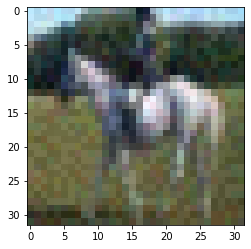

In [4]:
plt.imshow(clipped[0][i].cpu().numpy().transpose(1, 2, 0))
ad_model_pred = fmodel(clipped[0][i][None, :, :, :])
#print(ad_model_pred)
print(nn.Softmax(dim=1)(ad_model_pred))
print(classes[int(ad_model_pred.argmax())])

In [5]:
# So for the image of ship, we see that prob drops from 46% to 17% and aeroplane rises from 16% to 34%
# Now let me run the images and ensure both are giving correct results
# Obtain the logits by loading the weights on the VGG model
from vgg_inference import VGG
inf_model = VGG(0.3).to(device)
inf_model.load_state_dict(torch.load("/home/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
inf_model.eval()
pred = inf_model(X[i][None, :, :, :])

# Get softmax predicitons
print(nn.Softmax(dim=1)(pred))
# Get the class label
print(classes[int(pred.argmax())])

pred = inf_model(clipped[0][i][None, :, :, :])

# Get softmax predicitons
print(nn.Softmax(dim=1)(pred))
# Get the class label
print(classes[int(pred.argmax())])
# THe model is working as expected, cool

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
plt.imshow(X[0].cpu().numpy().transpose(1, 2, 0))

image_pair = torch.stack([X[i], X[0]] ,axis=0)
pred = inf_model(image_pair)
# Get softmax predicitons
print(nn.Softmax(dim=1)(pred))
# Get the class label
print(classes[int(pred.argmax())])